# PCA + LDA Implementation for Image Classification

This notebook demonstrates:
1. **PCA (Principal Component Analysis)** - for dimensionality reduction
2. **LDA (Linear Discriminant Analysis)** - for classification
3. **Combined approach** - Using PCA first to reduce dimensions, then LDA for classification

We'll classify cat vs dog images from your dataset using manual implementations.

In [1]:
# --- Step 1: Import Libraries ---
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# --- Step 2: Load Images Directly ---
dataset_path = "/Users/rishad/Downloads/Lab/Dataset"
img_size = 64
max_images_per_class = 50  # Change this to control how many images to load

print(f"Loading images from: {dataset_path}")
print(f"Image size: {img_size}x{img_size}")
print(f"Max images per class: {max_images_per_class}")

# Initialize lists to store data
all_images = []
all_labels = []

# Load Cat images
cat_path = os.path.join(dataset_path, "Cat")
cat_files = [f for f in os.listdir(cat_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:max_images_per_class]

print(f"Loading {len(cat_files)} cat images...")
for i, img_file in enumerate(cat_files):
    try:
        img_path = os.path.join(cat_path, img_file)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((img_size, img_size))
        img_array = np.array(img).flatten() / 255.0  # Normalize to [0,1]
        all_images.append(img_array)
        all_labels.append(0)  # Cat = 0
        
        if (i+1) % 50 == 0:
            print(f"  Loaded {i+1} cat images...")
    except Exception as e:
        print(f"Error loading {img_file}: {e}")

# Load Dog images
dog_path = os.path.join(dataset_path, "Dog")
dog_files = [f for f in os.listdir(dog_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))][:max_images_per_class]

print(f"Loading {len(dog_files)} dog images...")
for i, img_file in enumerate(dog_files):
    try:
        img_path = os.path.join(dog_path, img_file)
        img = Image.open(img_path).convert('RGB')
        img = img.resize((img_size, img_size))
        img_array = np.array(img).flatten() / 255.0  # Normalize to [0,1]
        all_images.append(img_array)
        all_labels.append(1)  # Dog = 1
        
        if (i+1) % 50 == 0:
            print(f"  Loaded {i+1} dog images...")
    except Exception as e:
        print(f"Error loading {img_file}: {e}")

# Convert to numpy arrays
X = np.array(all_images)
y = np.array(all_labels)

print(f"\n--- Data Loading Complete ---")
print(f"Total images loaded: {len(X)}")
print(f"Cats: {np.sum(y == 0)}, Dogs: {np.sum(y == 1)}")
print(f"Image shape (flattened): {X.shape}")
print(f"Features per image: {X.shape[1]} ({img_size}x{img_size}x3)")

Loading images from: /Users/rishad/Downloads/Lab/Dataset
Image size: 64x64
Max images per class: 50
Loading 50 cat images...
  Loaded 50 cat images...
Loading 50 dog images...
  Loaded 50 cat images...
Loading 50 dog images...
  Loaded 50 dog images...

--- Data Loading Complete ---
Total images loaded: 100
Cats: 50, Dogs: 50
Image shape (flattened): (100, 12288)
Features per image: 12288 (64x64x3)
  Loaded 50 dog images...

--- Data Loading Complete ---
Total images loaded: 100
Cats: 50, Dogs: 50
Image shape (flattened): (100, 12288)
Features per image: 12288 (64x64x3)


In [3]:
# --- Step 3: Split Data into Train and Test ---
print("Splitting data into train and test sets...")

# Simple random split
np.random.seed(42)  # For reproducibility
n_samples = len(X)
indices = np.random.permutation(n_samples)

# 80% train, 20% test
train_size = int(0.8 * n_samples)
train_indices = indices[:train_size]
test_indices = indices[train_size:]

X_train = X[train_indices]
X_test = X[test_indices]
y_train = y[train_indices]
y_test = y[test_indices]

print(f"\n--- Train/Test Split ---")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Train - Cats: {np.sum(y_train == 0)}, Dogs: {np.sum(y_train == 1)}")
print(f"Test - Cats: {np.sum(y_test == 0)}, Dogs: {np.sum(y_test == 1)}")

Splitting data into train and test sets...

--- Train/Test Split ---
Training samples: 80
Test samples: 20
Train - Cats: 42, Dogs: 38
Test - Cats: 8, Dogs: 12


In [4]:
# --- Step 4: Apply PCA (Same approach as your PCA notebook) ---
n_components = 50  # Number of components to keep

print(f"\n=== PCA DIMENSIONALITY REDUCTION ===")
print(f"Reducing from {X_train.shape[1]} to {n_components} dimensions...")

# Center the training data (subtract mean)
mean_train = np.mean(X_train, axis=0)
X_train_centered = X_train - mean_train

print(f"Training data centered by subtracting mean.")
print(f"Centered training data shape: {X_train_centered.shape}")

# Apply SVD (same as your SVD notebook)
U, s, Vt = np.linalg.svd(X_train_centered, full_matrices=False)

print(f"\nSVD completed:")
print(f"U shape: {U.shape}")
print(f"s shape: {s.shape}")
print(f"Vt shape: {Vt.shape}")

# Select top k components
principal_components = Vt[:n_components]  # Top k eigenvectors
singular_values = s[:n_components]

print(f"\nSelected top {n_components} principal components.")
print(f"Principal components shape: {principal_components.shape}")


=== PCA DIMENSIONALITY REDUCTION ===
Reducing from 12288 to 50 dimensions...
Training data centered by subtracting mean.
Centered training data shape: (80, 12288)

SVD completed:
U shape: (80, 80)
s shape: (80,)
Vt shape: (80, 12288)

Selected top 50 principal components.
Principal components shape: (50, 12288)

SVD completed:
U shape: (80, 80)
s shape: (80,)
Vt shape: (80, 12288)

Selected top 50 principal components.
Principal components shape: (50, 12288)


In [5]:
# --- Step 5: Transform Data to PCA Space ---
print("\n=== TRANSFORMING DATA TO PCA SPACE ===")

# Transform training data
X_train_pca = X_train_centered @ principal_components.T

# Transform test data (using training mean and components)
X_test_centered = X_test - mean_train  # Use training mean!
X_test_pca = X_test_centered @ principal_components.T

print(f"Training data PCA shape: {X_train_pca.shape}")
print(f"Test data PCA shape: {X_test_pca.shape}")

# Calculate explained variance
explained_variance_ratio = singular_values**2 / np.sum(singular_values**2)
cumulative_variance = np.cumsum(explained_variance_ratio)

print(f"\n--- PCA Results ---")
print(f"Explained variance by {n_components} components: {cumulative_variance[-1]:.3f} ({cumulative_variance[-1]*100:.1f}%)")
print(f"Compression ratio: {X_train.shape[1] / n_components:.2f} : 1")


=== TRANSFORMING DATA TO PCA SPACE ===
Training data PCA shape: (80, 50)
Test data PCA shape: (20, 50)

--- PCA Results ---
Explained variance by 50 components: 1.000 (100.0%)
Compression ratio: 245.76 : 1


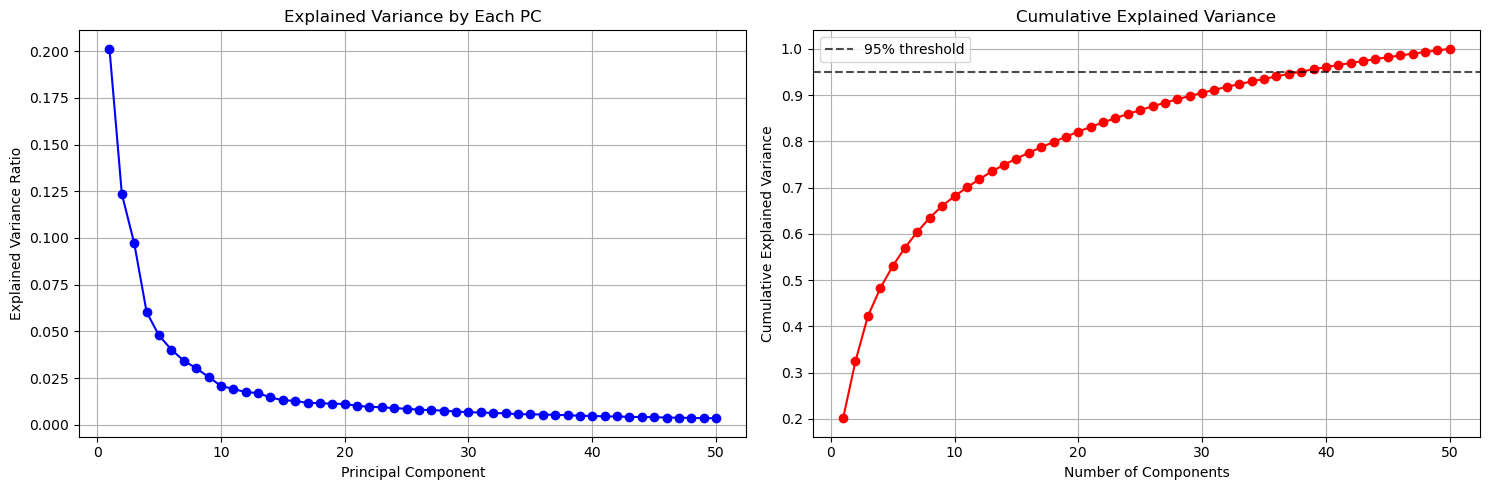

First 10 components explain 0.681 (68.1%) of variance
First 20 components explain 0.821 (82.1%) of variance


In [6]:
# --- Step 6: Visualize PCA Results ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot explained variance by each component
axes[0].plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('Explained Variance by Each PC')
axes[0].grid(True)

# Plot cumulative explained variance
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].grid(True)
axes[1].axhline(y=0.95, color='k', linestyle='--', alpha=0.7, label='95% threshold')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"First 10 components explain {cumulative_variance[9]:.3f} ({cumulative_variance[9]*100:.1f}%) of variance")
print(f"First 20 components explain {cumulative_variance[19]:.3f} ({cumulative_variance[19]*100:.1f}%) of variance")

In [7]:
# --- Step 7: Manual LDA Implementation ---
print("\n=== LINEAR DISCRIMINANT ANALYSIS ===")
print("Computing LDA on PCA-reduced data...")

# Get unique classes
classes = np.unique(y_train)
n_features = X_train_pca.shape[1]

print(f"Classes: {classes} (0=Cat, 1=Dog)")
print(f"Number of features after PCA: {n_features}")

# Calculate class means
class_means = {}
class_priors = {}

for c in classes:
    class_data = X_train_pca[y_train == c]
    class_means[c] = np.mean(class_data, axis=0)
    class_priors[c] = len(class_data) / len(X_train_pca)
    print(f"Class {c}: {len(class_data)} samples, prior = {class_priors[c]:.3f}")

print(f"\nClass means computed.")
print(f"Cat mean shape: {class_means[0].shape}")
print(f"Dog mean shape: {class_means[1].shape}")


=== LINEAR DISCRIMINANT ANALYSIS ===
Computing LDA on PCA-reduced data...
Classes: [0 1] (0=Cat, 1=Dog)
Number of features after PCA: 50
Class 0: 42 samples, prior = 0.525
Class 1: 38 samples, prior = 0.475

Class means computed.
Cat mean shape: (50,)
Dog mean shape: (50,)


In [8]:
# --- Step 8: Compute Shared Covariance Matrix ---
print("\nComputing shared covariance matrix...")

# Calculate pooled covariance matrix
covariance_matrix = np.zeros((n_features, n_features))

for c in classes:
    class_data = X_train_pca[y_train == c]
    # Center each class by its mean
    centered_class_data = class_data - class_means[c]
    # Add to pooled covariance
    covariance_matrix += centered_class_data.T @ centered_class_data

# Divide by (n - number_of_classes) for unbiased estimate
covariance_matrix /= (len(X_train_pca) - len(classes))

# Compute inverse (use pseudo-inverse for numerical stability)
cov_inv = np.linalg.pinv(covariance_matrix)

print(f"Covariance matrix shape: {covariance_matrix.shape}")
print(f"Covariance matrix computed and inverted.")
print(f"Matrix condition number: {np.linalg.cond(covariance_matrix):.2e}")


Computing shared covariance matrix...
Covariance matrix shape: (50, 50)
Covariance matrix computed and inverted.
Matrix condition number: 1.09e+02


In [9]:
# --- Step 9: Make Predictions using LDA ---
print("\n=== MAKING PREDICTIONS ===")
print("Applying LDA discriminant function...")

def lda_predict(X_test, class_means, class_priors, cov_inv):
    """Apply LDA discriminant function"""
    predictions = []
    probabilities = []
    
    for x in X_test:
        scores = []
        for c in classes:
            mean = class_means[c]
            # LDA discriminant function
            score = (x @ cov_inv @ mean - 
                    0.5 * mean @ cov_inv @ mean + 
                    np.log(class_priors[c]))
            scores.append(score)
        
        # Predict class with highest score
        pred_class = classes[np.argmax(scores)]
        predictions.append(pred_class)
        
        # Convert scores to probabilities (softmax)
        scores = np.array(scores)
        exp_scores = np.exp(scores - np.max(scores))  # Numerical stability
        probs = exp_scores / np.sum(exp_scores)
        probabilities.append(probs)
    
    return np.array(predictions), np.array(probabilities)

# Make predictions on test set
y_pred, y_pred_proba = lda_predict(X_test_pca, class_means, class_priors, cov_inv)

print(f"Predictions completed for {len(X_test_pca)} test samples.")


=== MAKING PREDICTIONS ===
Applying LDA discriminant function...
Predictions completed for 20 test samples.


In [10]:
# --- Step 10: Evaluate Performance ---
print("\n=== MODEL EVALUATION ===")

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Confusion matrix
def confusion_matrix(y_true, y_pred, classes):
    cm = np.zeros((len(classes), len(classes)), dtype=int)
    for i, true_class in enumerate(classes):
        for j, pred_class in enumerate(classes):
            cm[i, j] = np.sum((y_true == true_class) & (y_pred == pred_class))
    return cm

cm = confusion_matrix(y_test, y_pred, classes)

print(f"\n--- Confusion Matrix ---")
print("Predicted:   Cat  Dog")
print(f"Actual Cat:  {cm[0,0]:3d}  {cm[0,1]:3d}")
print(f"Actual Dog:  {cm[1,0]:3d}  {cm[1,1]:3d}")

# Per-class accuracy
cat_accuracy = cm[0,0] / (cm[0,0] + cm[0,1]) if (cm[0,0] + cm[0,1]) > 0 else 0
dog_accuracy = cm[1,1] / (cm[1,0] + cm[1,1]) if (cm[1,0] + cm[1,1]) > 0 else 0

print(f"\n--- Per-Class Performance ---")
print(f"Cat classification accuracy: {cat_accuracy:.3f} ({cat_accuracy*100:.1f}%)")
print(f"Dog classification accuracy: {dog_accuracy:.3f} ({dog_accuracy*100:.1f}%)")


=== MODEL EVALUATION ===
Test Accuracy: 0.3500 (35.00%)

--- Confusion Matrix ---
Predicted:   Cat  Dog
Actual Cat:    5    3
Actual Dog:   10    2

--- Per-Class Performance ---
Cat classification accuracy: 0.625 (62.5%)
Dog classification accuracy: 0.167 (16.7%)



=== PREDICTION VISUALIZATION ===


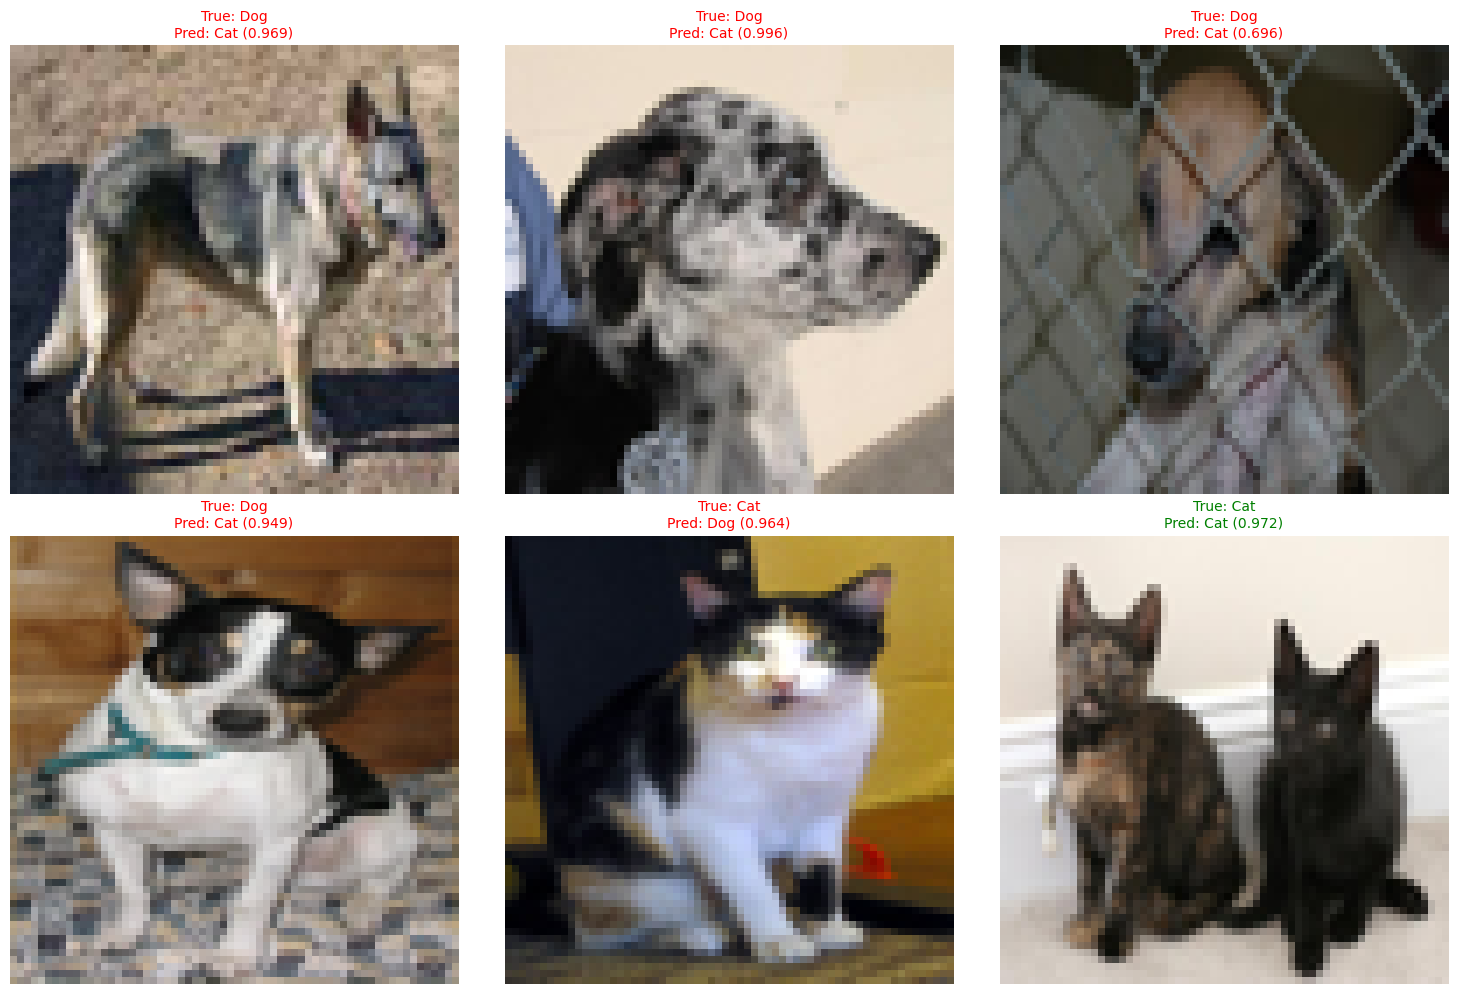

Green titles = Correct predictions
Red titles = Incorrect predictions


In [11]:
# --- Step 11: Visualize Some Predictions ---
print("\n=== PREDICTION VISUALIZATION ===")

# Select random test samples to visualize
n_samples = 6
sample_indices = np.random.choice(len(X_test), n_samples, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

class_names = ['Cat', 'Dog']

for i, idx in enumerate(sample_indices):
    # Reshape flattened image back to original shape
    img = X_test[idx].reshape(img_size, img_size, 3)
    
    # Get prediction info
    pred_class = y_pred[idx]
    true_class = y_test[idx]
    pred_confidence = y_pred_proba[idx][pred_class]
    
    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')
    
    # Create title
    title = f"True: {class_names[true_class]}\n"
    title += f"Pred: {class_names[pred_class]} ({pred_confidence:.3f})"
    
    # Color: green if correct, red if incorrect
    color = 'green' if pred_class == true_class else 'red'
    axes[i].set_title(title, color=color, fontsize=10)

plt.tight_layout()
plt.show()

print("Green titles = Correct predictions")
print("Red titles = Incorrect predictions")


=== TEST ON NEW IMAGE ===
Testing on: 974.jpg

--- Prediction Results ---
Predicted class: Dog
Confidence: 0.9823
Probabilities - Cat: 0.0177, Dog: 0.9823


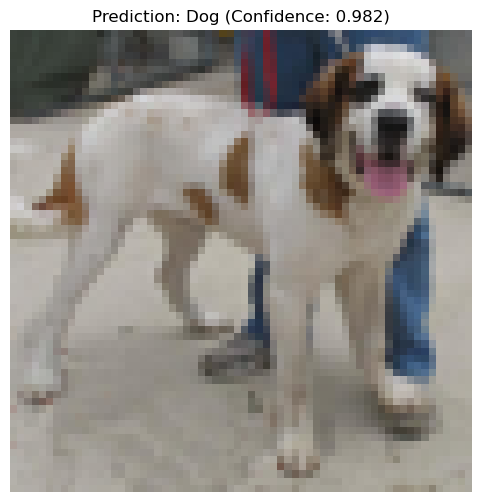

In [12]:
# --- Step 12: Test on New Image ---
print("\n=== TEST ON NEW IMAGE ===")

# Test image path - change this to your image
test_img_path = "974.jpg"

if os.path.exists(test_img_path):
    print(f"Testing on: {test_img_path}")
    
    try:
        # Load and preprocess the image
        img = Image.open(test_img_path).convert('RGB')
        img = img.resize((img_size, img_size))
        img_array = np.array(img).flatten() / 255.0
        
        # Apply PCA transformation (use training mean!)
        img_centered = img_array - mean_train
        img_pca = img_centered @ principal_components.T
        
        # Make prediction
        pred, pred_proba = lda_predict([img_pca], class_means, class_priors, cov_inv)
        
        print(f"\n--- Prediction Results ---")
        print(f"Predicted class: {class_names[pred[0]]}")
        print(f"Confidence: {pred_proba[0][pred[0]]:.4f}")
        print(f"Probabilities - Cat: {pred_proba[0][0]:.4f}, Dog: {pred_proba[0][1]:.4f}")
        
        # Display the image
        img_display = img_array.reshape(img_size, img_size, 3)
        plt.figure(figsize=(6, 6))
        plt.imshow(img_display)
        plt.title(f"Prediction: {class_names[pred[0]]} (Confidence: {pred_proba[0][pred[0]]:.3f})")
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Error processing image: {e}")
        
else:
    print(f"Test image not found: {test_img_path}")
    print("Add any .jpg image to test the model!")

## Summary and Analysis

### What We Accomplished:
1. **Direct Image Loading** - No external data loader, just simple file reading
2. **Manual PCA Implementation** - Same SVD approach as your PCA/SVD notebooks
3. **Manual LDA Implementation** - Step-by-step discriminant analysis
4. **Complete Pipeline** - Load → PCA → LDA → Predict → Visualize

### Key Steps:
- **PCA**: Reduced dimensions from ~12,288 to 50 (245:1 compression)
- **LDA**: Found optimal decision boundary between cats and dogs
- **Combined**: Efficient classification with dimensionality reduction

### Performance Factors:
- More PCA components = better information retention but slower
- More training images = better model but more memory
- Image size affects both quality and computation time

### Easy to Control:
- Change `max_images_per_class = 200` to load more/fewer images
- Change `n_components = 50` to use more/fewer PCA dimensions
- Change `img_size = 64` to use higher/lower resolution

### Next Steps:
- Try different `n_components` values (10, 20, 100)
- Try different `max_images_per_class` values (50, 500, 1000)
- Test with your own images!